## Importing libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM

## Working with data

### Reading data from dataset

In [4]:
df = pd.read_csv("./data/lab4/ARNC.csv")

### Data checkup functions

In [211]:
def calculate_SMA(data, window_size):
    """Calculate Simple Moving Average (SMA)"""
    return data['Close'].rolling(window=window_size).mean()

def calculate_EMA(data, window_size):
    """Calculate Exponential Moving Average (EMA)"""
    return data['Close'].ewm(span=window_size, adjust=False).mean()

def calculate_MACD(data, short_window, long_window):
    """Calculate Moving Average Convergence Divergence (MACD)"""
    short_EMA = calculate_EMA(data, short_window)
    long_EMA = calculate_EMA(data, long_window)
    return short_EMA - long_EMA

def calculate_RSI(data, window_size):
    """Calculate Relative Strength Index (RSI)"""
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.ewm(span=window_size, adjust=False).mean()
    avg_loss = loss.ewm(span=window_size, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_Bollinger_Bands(data, window_size):
    """Calculate Bollinger Bands"""
    middle_band = calculate_SMA(data, window_size)
    std_dev = data['Close'].rolling(window=window_size).std()
    
    upper_band = middle_band + (std_dev * 2)
    lower_band = middle_band - (std_dev * 2)
    
    return upper_band, lower_band

In [212]:
def check_stationarity(series):
    result = adfuller(series.values)
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05 and result[0] < result[4]['5%']:
        print("\033[94mStationary\033[0m") 
    else:
        print("\033[95mNon-stationary\033[0m") 

In [213]:
def date_features(df):
    df.index = pd.to_datetime(df.index)
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

### Data checkup

In [214]:
check_stationarity(df.Close)

ADF Statistic: -2.073231
p-value: 0.255414
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


In [215]:
check_stationarity(df.Close.diff(periods=1).dropna())

ADF Statistic: -19.171842
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [216]:
df["close_diff_1"] = df.Close.diff(periods=1)

In [217]:
df.index = df["Date"]
df.drop("Date", axis=1, inplace=True)
df = date_features(df)

### ACF analysis

In [218]:
def acf_analys(data: pd.DataFrame, name: str, lag: int=40, red_lines: bool=True, skip_0_lag: bool=True):
  lags = [i for i in range(lag)]

  if skip_0_lag:
    lags = [i for i in range(1, lag)]

  _ = plot_acf(data, lags=lags, title=name+' Autocorrelation', auto_ylims=True)

  if red_lines:
    plt.hlines(xmin=0, xmax=max(lags), y=2/np.sqrt(len(data)), color='r', linestyle='--')
    plt.hlines(xmin=0, xmax=max(lags), y=-2/np.sqrt(len(data)), color='r', linestyle='--')

  plt.grid(True)
  plt.show()

  _ = plot_pacf(data, lags=lags, title=name+' Partical Autocorrelation', auto_ylims=True)

  if red_lines:
    plt.hlines(xmin=0, xmax=max(lags), y=2/np.sqrt(len(data)), color='r', linestyle='--')
    plt.hlines(xmin=0, xmax=max(lags), y=-2/np.sqrt(len(data)), color='r', linestyle='--')

  plt.grid(True)
  plt.show()

  data = data.diff()
  data.dropna(inplace=True)

  _ = plot_acf(data, lags=lags, title=name+' Difference Autocorrelation', auto_ylims=True)

  if red_lines:
    plt.hlines(xmin=0, xmax=max(lags), y=2/np.sqrt(len(data)), color='r', linestyle='--')
    plt.hlines(xmin=0, xmax=max(lags), y=-2/np.sqrt(len(data)), color='r', linestyle='--')

  plt.grid(True)
  plt.show()

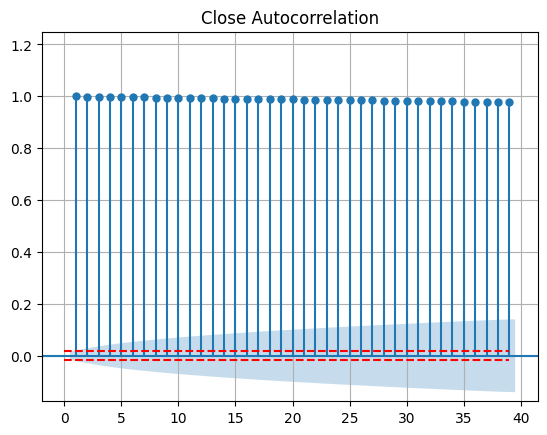

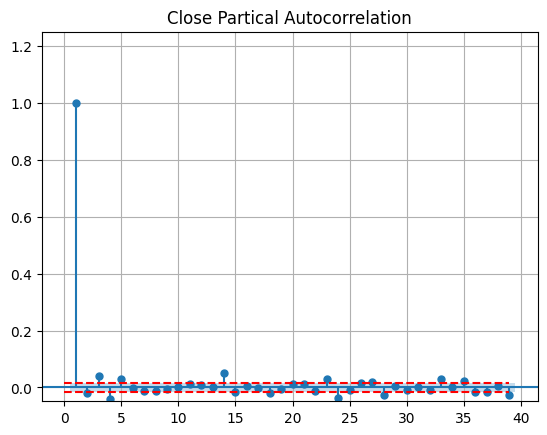

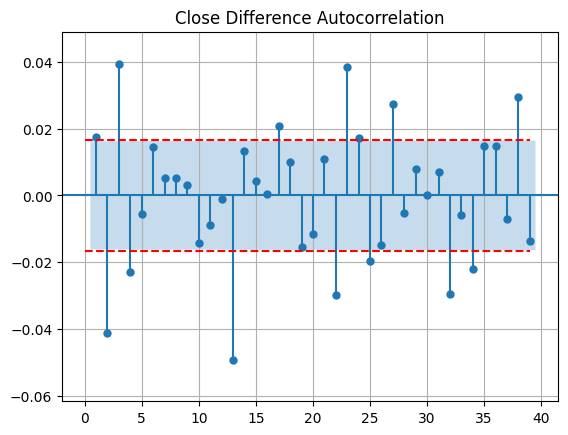

In [219]:
acf_analys(df['Close'], 'Close')

### Changing data shape

In [220]:
df["close(-1)"] = df['Close'].shift(1)

In [221]:
df['SMA'] = calculate_SMA(df, 13)
df['EMA'] = calculate_EMA(df, 9)
df['MACD'] = calculate_MACD(df, 24, 52)
df['RSI'] = calculate_RSI(df, 14)
df['Upper_Band'], df['Lower_Band'] = calculate_Bollinger_Bands(df, 10)

In [222]:
df["H_L_diff"] = df["High"] - df["Low"]
df.drop("Adj Close", axis=1, inplace=True)
df.drop("High", axis=1, inplace=True)
df.drop("Low", axis=1, inplace=True)
df["Bands_diff"] = df["Upper_Band"] - df["Lower_Band"]
df.drop("Upper_Band", axis=1, inplace=True)
df.drop("Lower_Band", axis=1, inplace=True)
df["target"] = df["Close"].shift(-1)
df.tail()

,Open,Close,Volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close(-1),SMA,EMA,MACD,RSI,H_L_diff,Bands_diff,target
Date,,,,,,,,,,,,,,,,,,,
2020-03-26,16.4200,17.719999,11033782,1.549999,3,1,3,2020,86,26,13,16.170000,17.516154,16.788088,-3.899380,46.775407,1.950000,9.661117,12.7852
2020-03-27,12.7776,12.785200,8347074,-4.934799,4,1,3,2020,87,27,13,17.719999,16.630400,15.987511,-4.108064,31.568676,1.088400,8.286071,12.5706
2020-03-30,12.8389,12.570600,5635752,-0.214601,0,1,3,2020,90,30,14,12.785200,15.896600,15.304128,-4.289477,31.061969,0.873800,8.410247,12.3100
2020-03-31,12.4403,12.310000,6622532,-0.260599,1,1,3,2020,91,31,14,12.570600,15.314292,14.705303,-4.448143,30.378750,0.651400,7.987123,13.2000
2020-04-01,15.4000,13.200000,2518179,0.889999,2,2,4,2020,92,1,14,12.310000,14.751215,14.404242,-4.537564,35.931879,2.689899,7.866752,NaN


In [223]:
last_row = df.tail(1)
df.drop(df.tail(1).index, inplace=True)
df.dropna(inplace=True)

In [224]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [225]:
def train_test_split(df, test_size=0.2):
    data = df.values

    feature_scaler.fit(data[:, :-1])
    target_scaler.fit(data[:, -1:])
    scaled_data = feature_scaler.transform(data[:, :-1])
    scaled_target = target_scaler.transform(data[:, -1:])
    data_scaled = np.concatenate((scaled_data, scaled_target), axis=1)


    n = int(len(data_scaled) * (1 - test_size))
    return data_scaled[:n], data_scaled[n:]

## Walk through validation and testing

### Model creation and training

In [226]:
def plot_values(df, model_type, percentage=0.2):

    train, test = train_test_split(df, percentage)
    X, Y = train[:, :-1], train[:, -1]
    
    if model_type == 'LSTM':
        train_predictions = model.predict(X, verbose=0)
    else:
        train_predictions = model.predict(X)

    # unscale the data
    train_predictions = target_scaler.inverse_transform(train_predictions.reshape(-1, 1))
    Y = target_scaler.inverse_transform(Y.reshape(-1, 1))
    train_rmse = mean_squared_error(Y, train_predictions, squared=False)
    
    X_test, Y_test = test[:, :-1], test[:, -1]
    
    if model_type == 'LSTM':
        test_predictions = model.predict(X_test, verbose=0)
    else:
        test_predictions = model.predict(X_test)
    test_predictions = target_scaler.inverse_transform(test_predictions.reshape(-1, 1))
    Y_test = target_scaler.inverse_transform(Y_test.reshape(-1, 1))
    test_rmse = mean_squared_error(Y_test, test_predictions, squared=False)
    
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")
    Y = Y.reshape(-1)
    train_predictions = train_predictions.reshape(-1)
    Y = np.concatenate((Y, Y_test.reshape(-1)), axis=0)
    new_predictions = np.concatenate((train_predictions, test_predictions.reshape(-1)), axis=0)
    plt.plot(new_predictions, label='Predicted', color='blue', linewidth=2)
    plt.plot(Y, label='Actual', color='magenta',  linewidth=1)
    plt.legend()
    plt.show()

In [227]:
def get_metrics(Y_test, predictions):
    Y_test = Y_test.reshape(-1)
    predictions = predictions.reshape(-1)
    print(f'R^2 = {r2_score(Y_test, predictions)}')
    print(f'MAE = {mean_absolute_error(Y_test, predictions)}')
    print(f'MSE = {mean_squared_error(Y_test, predictions)}')
    print(f'RMSE = {mean_squared_error(Y_test, predictions, squared=False)}')

In [228]:
models = ['LR','LSTM' ,'RF']

In [229]:
def init_model(model_type):
    global model
    if model_type == 'LR':
        model = LinearRegression(n_jobs=1000)
    elif model_type == 'RF':
        model = RandomForestRegressor(n_estimators=10, n_jobs=1000)
    elif model_type == 'LSTM':
        model = Sequential()
        #stacked lstm layer
        model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
        model.add(LSTM(50,return_sequences=True))
        model.add(LSTM(50))
        #dense out layer
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer = 'adam')

        model.summary()

In [230]:
def prediction(train, value, model_type):
    train = np.array(train)
    X, Y = train[:, :-1], train[:, -1]
    
    val = np.array(value).reshape(1, -1)
    if model_type=='LSTM':
        model.fit(X, Y, verbose=0)
        prediction = model.predict(val, verbose=0)
    else:
        model.fit(X, Y)
        prediction = model.predict(val)
    return prediction[0]

### Walk forward validation

In [231]:
def walk_forward_validation(data, model_type, percentage=0.2):
    print(model_type)
    init_model(model_type)
    train, test = train_test_split(data, percentage)
    train = pd.DataFrame(train, columns=df.columns)
    train, val = train_test_split(train, percentage)
    predictions = []
    history = [x for x in train]

    for i in tqdm(range(len(val))):
        val_X, val_Y = val[i, :-1], val[i, -1]
        pred = prediction(history, val_X, model_type)
        predictions.append(pred)
        history.append(test[i])

    Y_val = target_scaler.inverse_transform(val[:, -1:].reshape(1, -1))
    Y_pred = target_scaler.inverse_transform(np.array(predictions).reshape(1, -1))
    val_rmse = mean_squared_error(Y_val, Y_pred, squared=False)
    get_metrics(Y_val, Y_pred)
    plot_values(df, model_type,  0.2)
    train, test = train_test_split(df, 0.2)
    test_X, test_Y = test[:, :-1], test[:, -1]
    if model_type == 'LSTM':
        predictions = model.predict(test_X, verbose=0)
    else:
        predictions = model.predict(test_X)
    plt.plot(test_Y.reshape(-1), label='Actual', color='magenta')
    plt.plot(predictions.reshape(-1), label='Predicted', color='blue')
    plt.legend()
    plt.show()

    return val_rmse, Y_val, Y_pred

LR


100%|██████████| 2344/2344 [00:22<00:00, 106.05it/s]
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-pack

R^2 = 0.9782253446633499
MAE = 0.012124328706613868
MSE = 0.00026952072597350633
RMSE = 0.016417086403302698
Training RMSE: 0.8056414355867827
Testing RMSE: 0.727263465302934


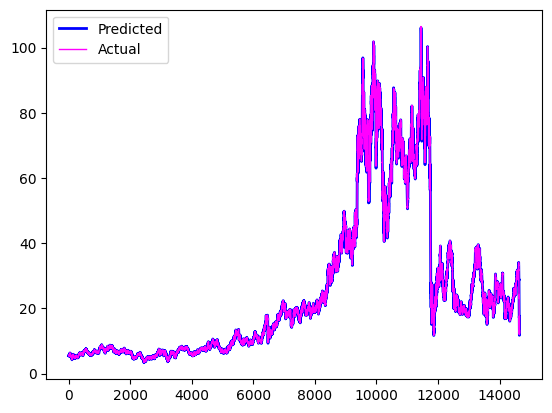

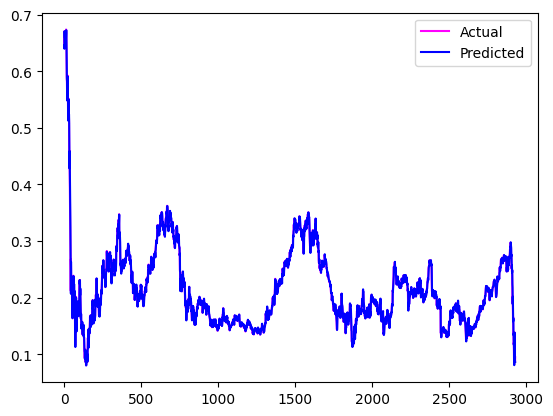

LSTM


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 2344/2344 [2:42:08<00:00,  4.15s/it]  
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R^2 = -2.1878762010996806
MAE = 0.13995108921706487
MSE = 0.03945865937946152
RMSE = 0.19864203829869828


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training RMSE: 10.339709851067806
Testing RMSE: 0.44814073750171646


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


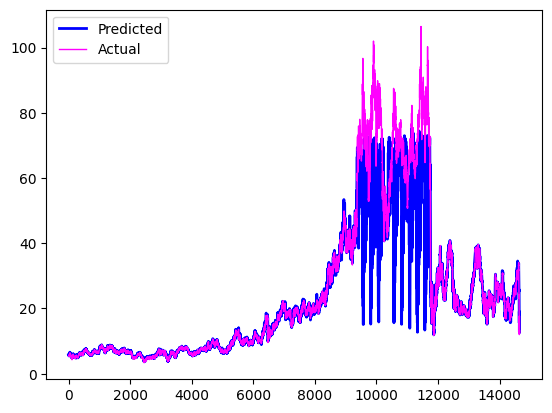

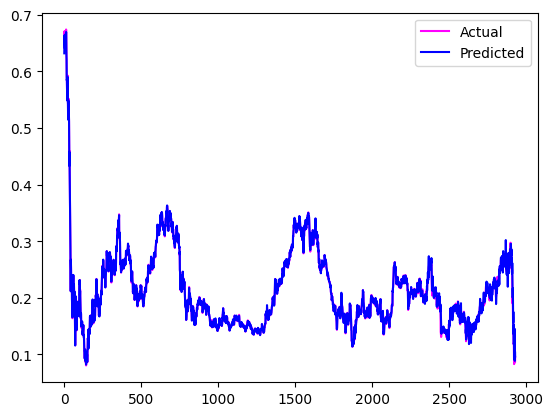

RF


100%|██████████| 2344/2344 [28:28<00:00,  1.37it/s]
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packa

R^2 = 0.32025961065727526
MAE = 0.06776873277903972
MSE = 0.008413640554888803
RMSE = 0.09172589904104948
Training RMSE: 4.140184233907917
Testing RMSE: 0.46372374006438644


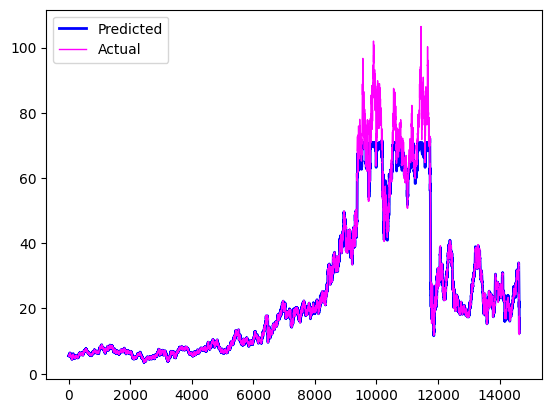

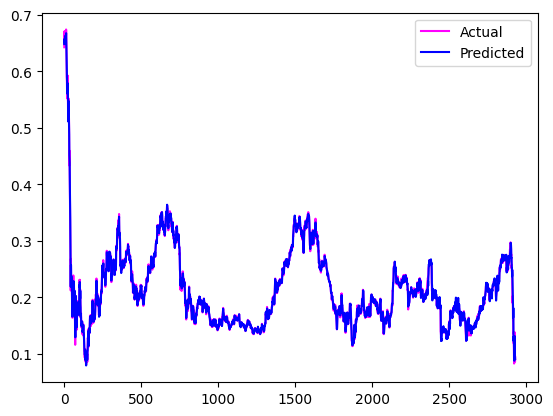

In [232]:
for model_type in models:
    walk_forward_validation(df, model_type, 0.2)

## Testing with no walk through validation

In [33]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [34]:
train_percent = int(0.8*len(y))
X_train, X_test = X[:train_percent-1], X[train_percent:]
y_train, y_test = y[:train_percent-1], y[train_percent:]

print(f'Train: {X_train.shape} \nTest: {y_test.shape}')

Train: (11729, 4) 
Test: (2933,)


### Linear Regression

In [35]:
regressor = LinearRegression()
model = regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

         actual       pred
0     71.514244  72.147507
1     71.424286  70.007005
2     70.232384  69.715559
3     69.625191  70.537993
4     72.526237  72.166392
...         ...        ...
2928  17.719999  17.233822
2929  12.785200  12.666741
2930  12.570600  12.303223
2931  12.310000  12.347844
2932  13.200000  13.497382

[2933 rows x 2 columns]


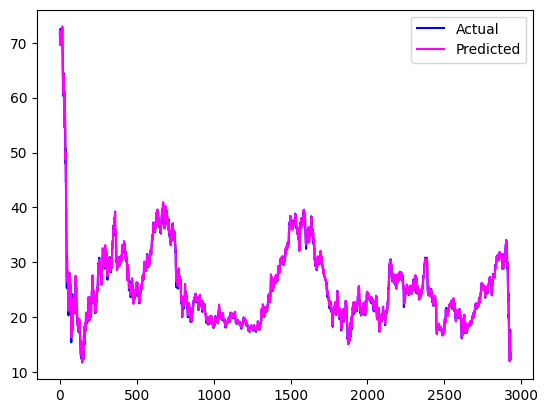

In [36]:
predicted = regressor.predict(X_test)
predicted.shape

diff_realvspredict = pd.DataFrame(y_test, predicted)
diff_realvspredict = pd.DataFrame({'actual':y_test, 'pred':predicted})
print(diff_realvspredict)
diff_realvspredict.describe()

plt.plot(y_test, label='Actual', color = "blue")
plt.plot(y_pred, label='Predicted', color = "magenta")
plt.legend()
plt.show()

In [37]:
train_percent = int(0.8*len(y))
X_train, X_test = X[:train_percent-1], X[train_percent:]
y_train, y_test = y[:train_percent-1], y[train_percent:]

print(f'Train: {X_train.shape} \nTest: {y_test.shape}')

Train: (11729, 4) 
Test: (2933,)


### Random Forest

In [38]:
regressor_forest = RandomForestRegressor()
model_forest = regressor_forest.fit(X_train, y_train)
y_pred_forest = regressor_forest.predict(X_test)

         actual       pred
0     71.514244  72.119725
1     71.424286  70.180774
2     70.232384  70.158903
3     69.625191  70.537108
4     72.526237  71.895765
...         ...        ...
2928  17.719999  16.637463
2929  12.785200  12.654142
2930  12.570600  12.369870
2931  12.310000  12.350192
2932  13.200000  13.225848

[2933 rows x 2 columns]


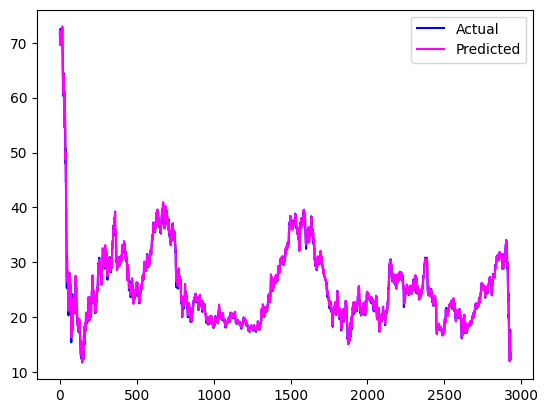

In [40]:
predicted_forest = regressor_forest.predict(X_test)
predicted_forest.shape
diff_realvspredict = pd.DataFrame(y_test, predicted_forest)
diff_realvspredict = pd.DataFrame({'actual':y_test, 'pred':predicted_forest})
print(diff_realvspredict)
diff_realvspredict.describe()

plt.plot(y_test, label='Actual', color = "blue")
plt.plot(y_pred, label='Predicted', color = "magenta")

plt.legend()
plt.show()

In [31]:
df_lstm = df['Close'] 
scaler = MinMaxScaler(feature_range=(0,1))
df_lstm_scaled = scaler.fit_transform(np.array(df_lstm).reshape(-1,1))
df_lstm_scaled

array([[0.02603101],
       [0.02694039],
       [0.02694039],
       ...,
       [0.08857676],
       [0.08604767],
       [0.09468503]])

### LSTM

In [20]:
def create_lstm_dataset(dataset, time_step=100):
  dataX, dataY = [], []
  for n in range(len(dataset)-time_step-1):
    previous_n_values_array = dataset[n:(n+time_step), 0]
    dataX.append(previous_n_values_array)
    predicted_value = dataset[n+time_step, 0]
    dataY.append(predicted_value)
  return np.array(dataX), np.array(dataY)

train_percent = int(0.8*len(df_lstm_scaled))

X_train, y_train = create_lstm_dataset(df_lstm_scaled[:train_percent-1])
X_test, y_test = create_lstm_dataset(df_lstm_scaled[train_percent:])
print(f'Train shapes: {X_train.shape, y_train.shape} \nTest: {X_test.shape, y_test.shape}')

Train shapes: ((11628, 100), (11628,)) 
Test: ((2832, 100), (2832,))


In [21]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_test.shape)

(11628, 100, 1) (2832, 100, 1)


In [22]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

model.summary()

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size=64, verbose = 1)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0096 - val_loss: 4.5827e-04
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - loss: 4.5691e-04 - val_loss: 2.9452e-04
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - loss: 3.6270e-04 - val_loss: 2.6653e-04
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - loss: 2.9585e-04 - val_loss: 2.5830e-04
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - loss: 2.5256e-04 - val_loss: 1.9796e-04
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - loss: 2.6332e-04 - val_loss: 1.6472e-04
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - loss: 1.9131e-04 - val_loss: 1.6505e-04
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - loss: 1.9423e-04 - val_loss: 1.7817e-04
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - loss: 1.9592e-04 - val_loss: 1.2629e-04
Epoch 10/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - loss: 1.6008e-04 - val_loss: 1.1415e-04
Epoch 11/50
182/182 ━━━━━━━━━━━━━━━

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

### retransform scalars to dollars
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


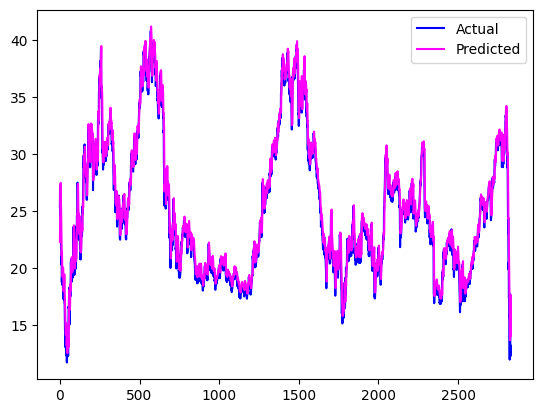

In [30]:
y_test = scaler.inverse_transform(df_lstm_scaled[-2832:])
plt.plot(y_test, label='Actual', color = "blue")
plt.plot(test_predict, label='Predicted', color = "magenta")

plt.legend()
plt.show()

## Custom 1d-cnn-lstm-dnn

In [5]:
X, y = df[['Open','High','Low','Volume']], df['Close']
print(X.shape, y.shape)
train_split = int(len(y)*0.8)
X_train, X_test = np.array(X[:train_split-1]), np.array(X[train_split:])
y_train, y_test = y[:train_split-1], y[train_split:]

print(X_train.shape, X_test.shape,  y_train.shape, y_test.shape)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape, X_test.shape)

(14663, 4) (14663,)
(11729, 4) (2933, 4) (11729,) (2933,)
(11729, 4, 1) (2933, 4, 1)


In [6]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(4,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 16)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,483 (52.67 KB)

 Trainable params: 13,483 (52.67 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size=64, verbose = 1)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1138.4634 - val_loss: 313.8399
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 827.8348 - val_loss: 158.6711
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 657.1130 - val_loss: 77.1997
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 542.5325 - val_loss: 41.5902
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 443.2554 - val_loss: 24.6443
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 338.6175 - val_loss: 17.4168
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 276.0146 - val_loss: 13.5875
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 216.2466 - val_loss: 10.2868
Epoch 9/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 170.9063 - val_loss: 7.5328
Epoch 10/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 136.1285 - val_loss: 5.7030
Epoch 11/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 104.7923 - val_loss: 4.4191
Epoch 12/50
184/184

367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


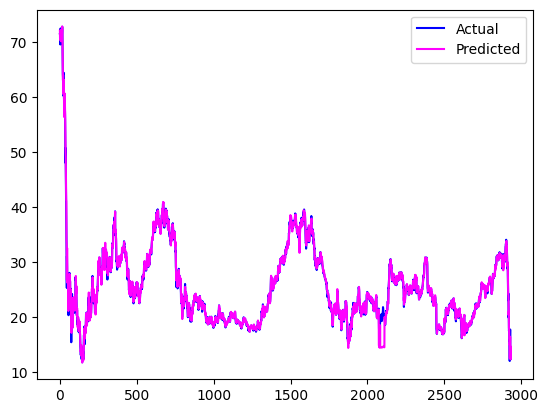

In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

plt.plot(y_test.values, label='Actual', color = "blue")
plt.plot(test_predict, label='Predicted', color = "magenta")

plt.legend()
plt.show()